In [1]:
# This notebook is meant to work towards tackling thw Olivetti dataset. A cluster of images of 
# different pwople wearing ddifferent expressions. The aim is to grop them well enough based 
# of their labels.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [3]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [4]:
# We are going to split the dataset, to ensure even weight distrubution, we will use
# StraifiedShuffleSplit. The dataset is a small number of images(400).

from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))

X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [5]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


In [6]:
# We'll use PCA to compress and speed things
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

np.int64(199)

In [7]:
# Next we will use KMeans to cluster the images, and find the optimal clusters of images

from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print(f"k={k}")
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


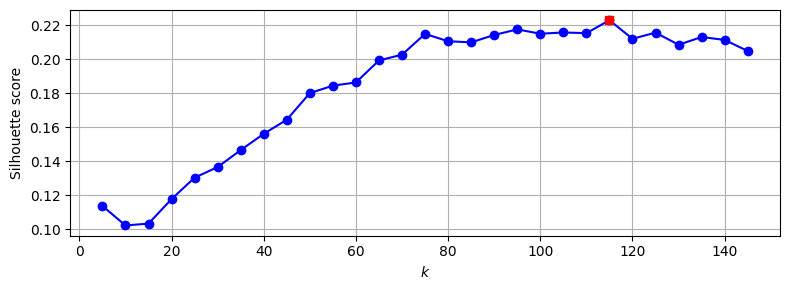

In [8]:
# Let us try and figure out the best number of clusters for the dataset. 

from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                    for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.plot(best_k, best_score, "rs")
plt.grid()
plt.tight_layout()

plt.show()

In [9]:
best_k

115

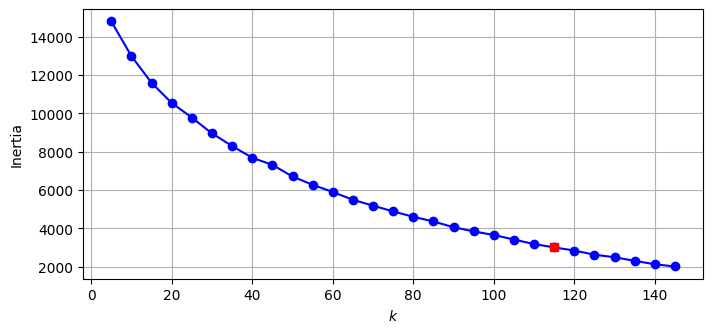

In [10]:
# We have found the best number of clusters to be at 115. It might been expected to be at 40
# since we have 40 people in the picture frame. But the same person may look similar because
# of glasses and stuff. Let's try and see we can figure out the best inertia

inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.plot(best_k, best_inertia, "rs")
plt.grid()

plt.show()

In [11]:
best_inertia

3004.916015625

In [12]:
# There's no visible elblow for inertias. So we'll stick with k=115
best_model = kmeans_per_k[best_index]

Cluster 0


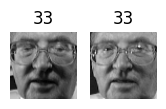

Cluster 1


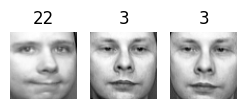

Cluster 2


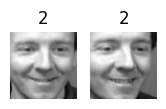

Cluster 3


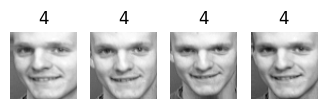

Cluster 4


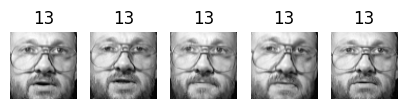

Cluster 5


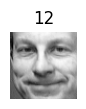

Cluster 6


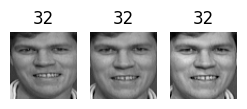

Cluster 7


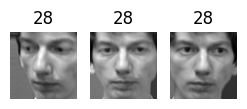

Cluster 8


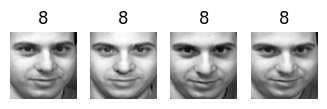

Cluster 9


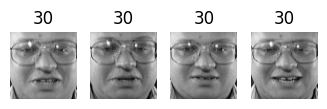

Cluster 10


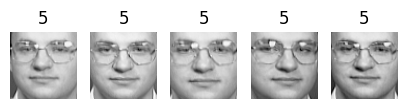

Cluster 11


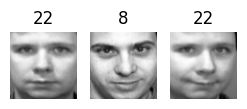

Cluster 12


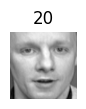

Cluster 13


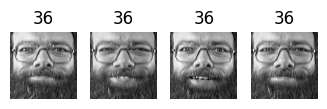

Cluster 14


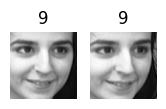

Cluster 15


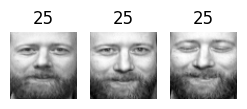

Cluster 16


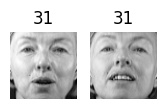

Cluster 17


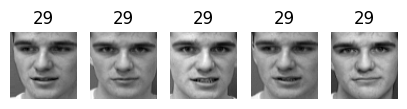

Cluster 18


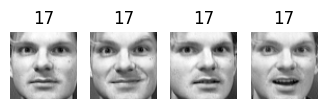

Cluster 19


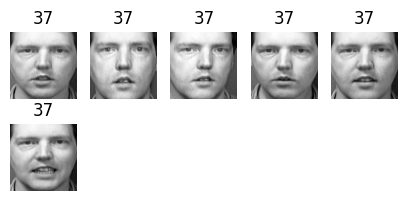

Cluster 20


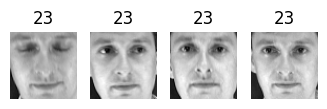

Cluster 21


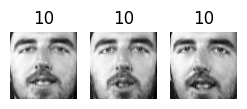

Cluster 22


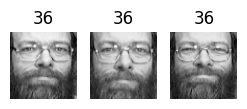

Cluster 23


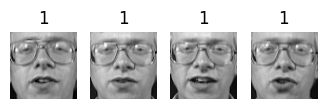

Cluster 24


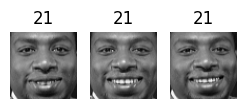

Cluster 25


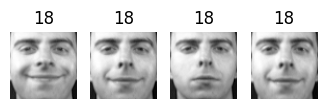

Cluster 26


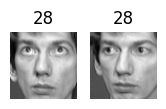

Cluster 27


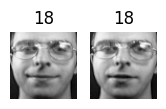

Cluster 28


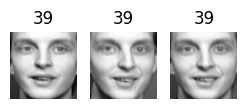

Cluster 29


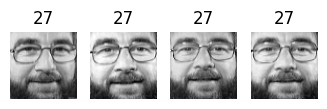

Cluster 30


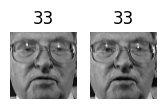

Cluster 31


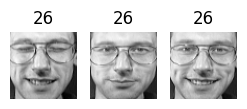

Cluster 32


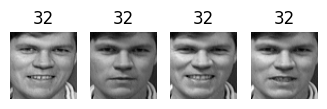

Cluster 33


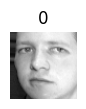

Cluster 34


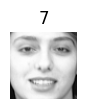

Cluster 35


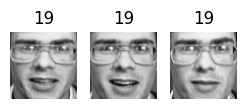

Cluster 36


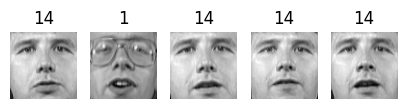

Cluster 37


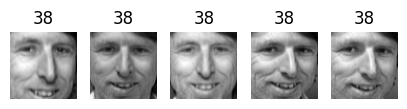

Cluster 38


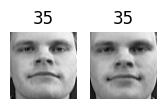

Cluster 39


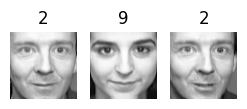

Cluster 40


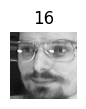

Cluster 41


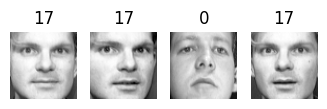

Cluster 42


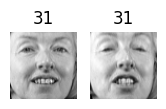

Cluster 43


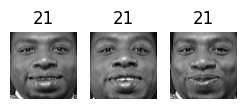

Cluster 44


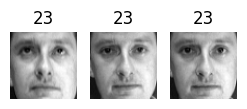

Cluster 45


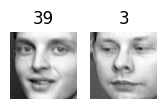

Cluster 46


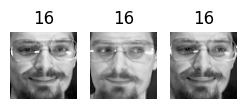

Cluster 47


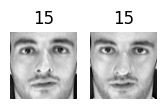

Cluster 48


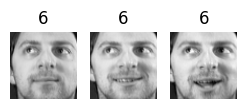

Cluster 49


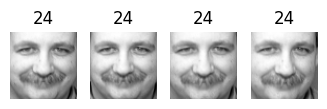

Cluster 50


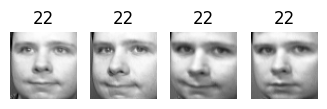

Cluster 51


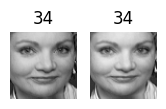

Cluster 52


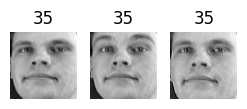

Cluster 53


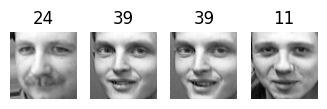

Cluster 54


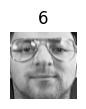

Cluster 55


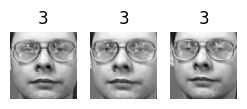

Cluster 56


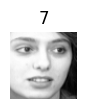

Cluster 57


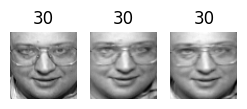

Cluster 58


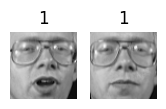

Cluster 59


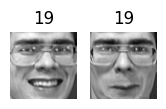

Cluster 60


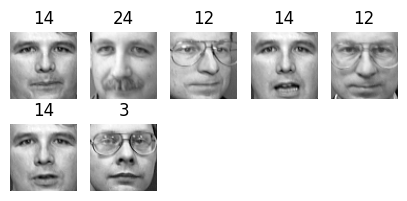

Cluster 61


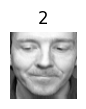

Cluster 62


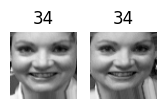

Cluster 63


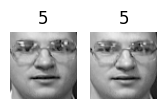

Cluster 64


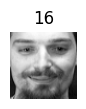

Cluster 65


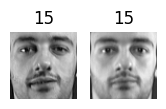

Cluster 66


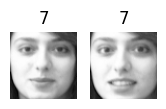

Cluster 67


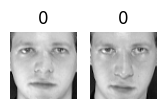

Cluster 68


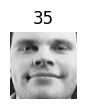

Cluster 69


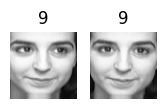

Cluster 70


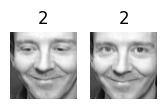

Cluster 71


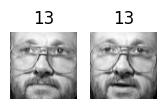

Cluster 72


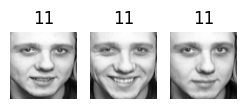

Cluster 73


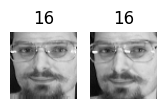

Cluster 74


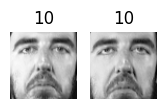

Cluster 75


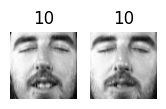

Cluster 76


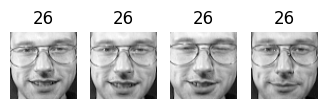

Cluster 77


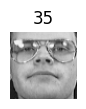

Cluster 78


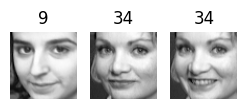

Cluster 79


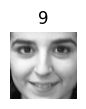

Cluster 80


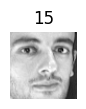

Cluster 81


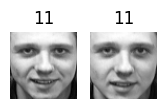

Cluster 82


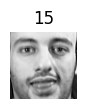

Cluster 83


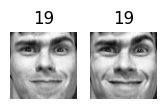

Cluster 84


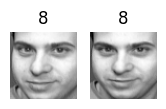

Cluster 85


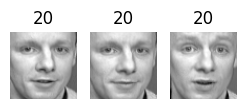

Cluster 86


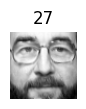

Cluster 87


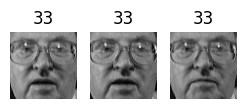

Cluster 88


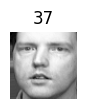

Cluster 89


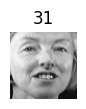

Cluster 90


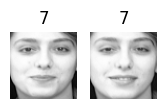

Cluster 91


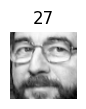

Cluster 92


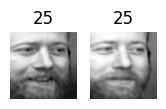

Cluster 93


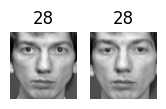

Cluster 94


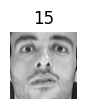

Cluster 95


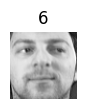

Cluster 96


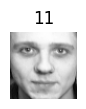

Cluster 97


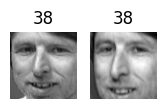

Cluster 98


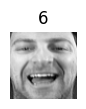

Cluster 99


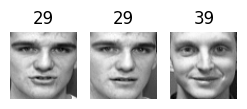

Cluster 100


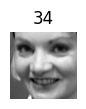

Cluster 101


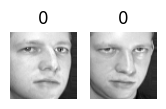

Cluster 102


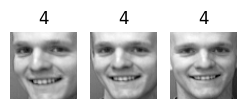

Cluster 103


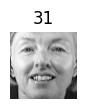

Cluster 104


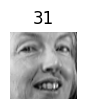

Cluster 105


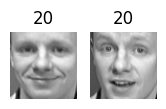

Cluster 106


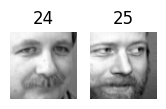

Cluster 107


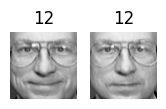

Cluster 108


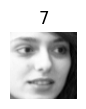

Cluster 109


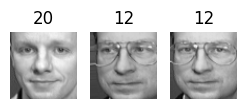

Cluster 110


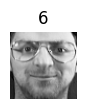

Cluster 111


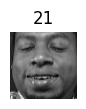

Cluster 112


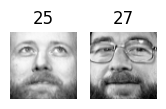

Cluster 113


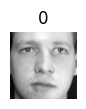

Cluster 114


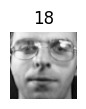

In [13]:
# Let us plot a cluster of the faces to have an idea which might be mismatched or not
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]

    plot_faces(faces, labels)

In [19]:
# Let us train a classifier that will be able to predct which person is represented

from sklearn.ensemble import RandomForestClassifier

rand_clf = RandomForestClassifier(n_estimators=150, random_state=42)
rand_clf.fit(X_train_pca, y_train)
rand_clf.score(X_valid_pca, y_valid)

0.9375

In [ ]:
# Using Gaussian mixture 

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=40, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

print(np.unique(gmm_labels, return_counts=True))

In [20]:
# Now we use keras-tuner and try to get the best parameters for the keral neura net

import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(X_train_pca.shape[1],)))

    learning_rate= hp.Float("learning_rate", min_value=1e-3, max_value=1e-1, sampling="log")
    optimizer = hp.Choice("optimizer", values=["adam", "adamw"])

    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4)

    # Tuning the number of layers and units
    for i in range(hp.Int("num_layers", 1, 2)):
        activation=hp.Choice("activation", ["relu", "selu"])
        kernel_initializer = "he_normal" if activation == "relu" else "lecun_normal"
        
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f"uinits_{i}", min_value=32, max_value=256, step=32),
            activation=activation,
            kernel_initializer=kernel_initializer
        ))
        model.add(tf.keras.layers.Dropout(rate=hp.Float(f"dropout_{i}", 0.1, 0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(40, activation="softmax")) 

    model.compile(optimizer=optimizer,
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])
    return model
    

In [21]:
from pathlib import Path

tuner = kt.tuners.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="olivetti_tuner",
    project_name="olivetti_dataset",
)

tuner.search(X_train_pca, y_train, epochs=10, validation_split=0.1)

best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.8571428656578064

Best val_accuracy So Far: 0.9285714030265808
Total elapsed time: 00h 00m 40s


C:\Users\user\anaconda3\envs\tf-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
from sklearn.metrics import accuracy_score

y_probs = best_model.predict(X_valid_pca)

y_pred = np.argmax(y_probs, axis=1)

print("Accuracy:", accuracy_score(y_valid, y_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Accuracy: 0.9375
